# 🧬 DNA Promoter Classification with Transformer

## 📦 Step 1: Imports + Preprocessing

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

# ✅ One-hot encode DNA sequences
def one_hot_encode(seq):
    mapping = {'a':[1,0,0,0], 't':[0,1,0,0], 'c':[0,0,1,0], 'g':[0,0,0,1]}
    return np.array([mapping.get(char, [0,0,0,0]) for char in seq.lower()])

# 📄 Load dataset
df = pd.read_csv("final_dataset.csv").dropna()
df = df[df['sequence'].apply(lambda x: isinstance(x, str))]
X = np.array([one_hot_encode(seq) for seq in df['sequence']])
y = df['label'].values

# 🔀 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 📦 Dataset class
class DNADataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(DNADataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(DNADataset(X_test, y_test), batch_size=64)


## 🧠 Step 2: Transformer Model for 1D DNA

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=60):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

class TransformerModel(nn.Module):
    def __init__(self, input_dim=4, model_dim=64, num_heads=4, num_layers=2, num_classes=2):
        super(TransformerModel, self).__init__()
        self.linear_in = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc1 = nn.Linear(model_dim, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.linear_in(x)                 # [B, L, D]
        x = self.pos_encoder(x)              # add positional info
        x = self.transformer(x)              # [B, L, D]
        x = x.mean(dim=1)                    # global average pooling
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


## 🚀 Step 3: Train the Transformer

In [3]:
def train_model(model, train_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        acc = 100 * correct / total
        print(f"📘 Epoch {epoch+1}/{epochs} — Loss: {total_loss/len(train_loader):.4f}, Accuracy: {acc:.2f}%")

    return model


## 📊 Step 4: Evaluate the Model

In [4]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model = model.to(device)

    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.numpy())

    print("\n🧾 Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title("🧪 Confusion Matrix (Transformer)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return all_preds, all_labels


## 📈 Step 5: ROC Curve

In [5]:
def plot_roc(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    y_probs, y_true = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            y_probs.extend(probs)
            y_true.extend(y_batch.numpy())

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='purple', label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("📈 ROC Curve (Transformer)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


## 🏁 Step 6: Train, Evaluate, Plot

📘 Epoch 1/10 — Loss: 0.6557, Accuracy: 59.27%
📘 Epoch 2/10 — Loss: 0.4991, Accuracy: 75.73%
📘 Epoch 3/10 — Loss: 0.4698, Accuracy: 77.45%
📘 Epoch 4/10 — Loss: 0.4672, Accuracy: 77.81%
📘 Epoch 5/10 — Loss: 0.4607, Accuracy: 77.83%
📘 Epoch 6/10 — Loss: 0.4617, Accuracy: 78.20%
📘 Epoch 7/10 — Loss: 0.4485, Accuracy: 79.10%
📘 Epoch 8/10 — Loss: 0.4164, Accuracy: 80.47%
📘 Epoch 9/10 — Loss: 0.3793, Accuracy: 82.49%
📘 Epoch 10/10 — Loss: 0.3667, Accuracy: 83.32%

🧾 Classification Report:
              precision    recall  f1-score   support

           0     0.8563    0.7933    0.8236       774
           1     0.8075    0.8669    0.8361       774

    accuracy                         0.8301      1548
   macro avg     0.8319    0.8301    0.8299      1548
weighted avg     0.8319    0.8301    0.8299      1548



C:\Users\dell\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


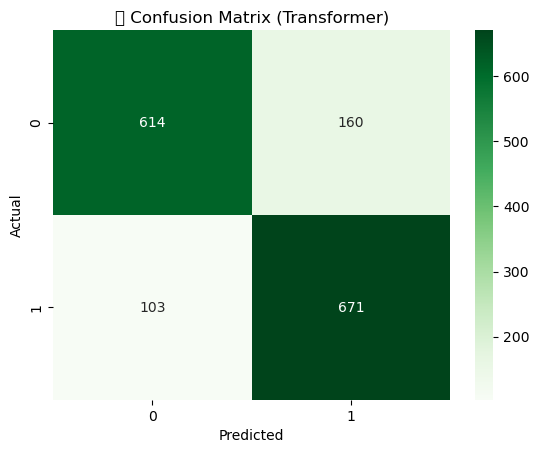

C:\Users\dell\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


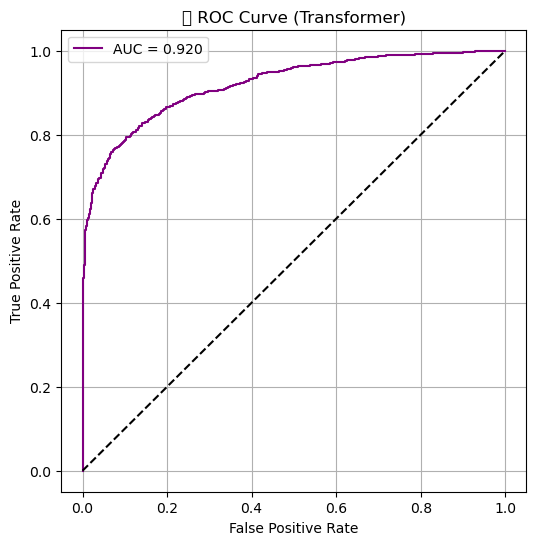

In [6]:
# ✅ Instantiate and train Transformer
model = TransformerModel()
model = train_model(model, train_loader, epochs=10)

# 🧪 Evaluate
preds, labels = evaluate_model(model, test_loader)

# 📈 ROC Curve
plot_roc(model, test_loader)
